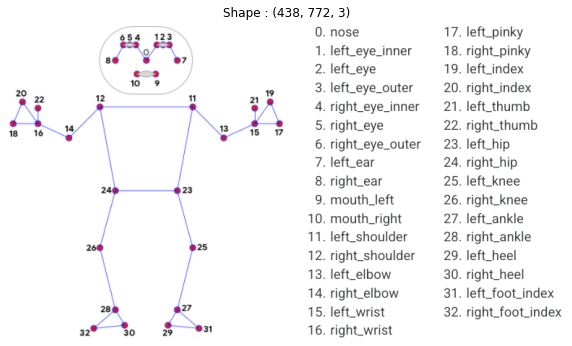

In [1]:
import cv2
import mediapipe as mp
import math
import matplotlib.pyplot as plt
%matplotlib inline


def display_image(image,convert = True):
    
    if convert:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize = (10,10))
    plt.imshow(image)
    plt.title(f"Shape : {image.shape}")
    plt.axis("off")
    plt.show()
    
path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/pose.png"
img = cv2.imread(path)

# Resim ters çevirili zaten !!!
display_image(img)

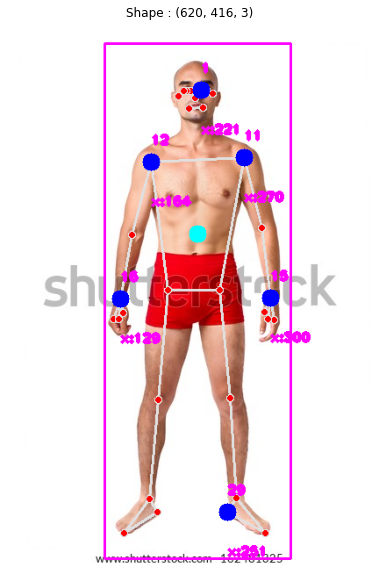

In [3]:
import cv2
import mediapipe as mp
import math
import time

mpDraw = mp.solutions.drawing_utils
mpPose = mp.solutions.pose
Pose = mpPose.Pose()

path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/body.jpeg"
image = cv2.imread(path)
imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

h,w,c = image.shape
results = Pose.process(imageRGB)


liste_id = [12,11,15,16,1,29]
lmList = []
if results.pose_landmarks:
    mpDraw.draw_landmarks(image,results.pose_landmarks,mpPose.POSE_CONNECTIONS)
    for id,lm in enumerate(results.pose_landmarks.landmark):
        cx,cy,cz = int(lm.x*w),int(lm.y*h),int(lm.z*w)
        lmList.append([id,cx,cy,cz])
        if id in liste_id:
            cv2.circle(image,(cx,cy),10,(255,0,0),cv2.FILLED)
            cv2.putText(image,str(id),(cx,cy-20),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),3)
            cv2.putText(image,f"x:{cx}",(cx,cy+50),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),3)
        
    ad = abs(lmList[12][1] - lmList[11][1]) // 2
    
    x1 = lmList[12][1] - ad
    x2 = lmList[11][1] + ad
    
    y2 = lmList[29][2] + ad
    y1 = lmList[1][2] - ad
    
    bbox = (x1,y1,x2,y2)
    
    cx,cy = lmList[12][1] + ad , (lmList[29][2] - lmList[1][2]) // 2
    
    #cv2.line(image,(x1,10),(x2,10),(255,0,255),2,cv2.LINE_AA)
    #cv2.line(image,(x1,40),(x3,40),(255,0,255),2,cv2.LINE_AA)
    
    #cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,255),2)
    cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,255),2)
    cv2.circle(image,(cx,cy),10,(255,255,0),cv2.FILLED)
        
display_image(image)

In [ ]:
import cv2
import mediapipe as mp 
import math
import time
import numpy as np

class PoseDetector:
    
    def __init__(self,mode = False,complexity = 1,smooth = True,
                 enable_seg = False,smooth_seg = True,detectionCon = 0.5, trackCon = 0.5):
        
        self.mode = mode
        self.complexity = complexity
        self.smooth = smooth
        self.enable_seg = enable_seg
        self.smooth_seg = smooth_seg
        self.detectionCon = detectionCon
        self.trackCon = trackCon
        
        self.mpDraw = mp.solutions.drawing_utils
        self.mpPose = mp.solutions.pose
        
        self.Pose = self.mpPose.Pose(self.mode,self.complexity,self.smooth,\
                                     self.enable_seg,self.smooth_seg,\
                                     self.detectionCon,self.trackCon)
        
    def findPose(self,image,draw = True):
        
        imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self.results = self.Pose.process(imageRGB)
        
        if self.results.pose_landmarks:
            if draw:
                self.mpDraw.draw_landmarks(image, self.results.pose_landmarks,
                                           self.mpPose.POSE_CONNECTIONS)
                
        return image
    
    def findPosition(self,image,draw = True,bboxWithHands = False):
        
        self.lmList = []
        self.bboxInfo = {}
        h,w,c = image.shape
        
        if self.results.pose_landmarks:
            for id,lm in enumerate(self.results.pose_landmarks.landmark):
                cx,cy,cz = int(lm.x*w),int(lm.y*h),int(lm.z*w)
                self.lmList.append([id,cx,cy])
                
            # Sağ Sol Omuz
            # Ortası 
            ad = abs(self.lmList[12][1] - self.lmList[11][1]) // 2
            if bboxWithHands:
                # Sağ Sol bilek
                # Burda kolları da dahil ediyoruz !!!
                x1 = self.lmList[16][1] - ad
                x2 = self.lmList[15][1] + ad
            else:
                # Burda sadece Omuz Dışarısını tarafını dahil ediyoruz !!!
                x1 = self.lmList[12][1] - ad
                x2 = self.lmList[11][1] + ad
            
            # 29 left heal , 1 left_eye_inner
            y2 = self.lmList[29][2] + ad
            y1 = self.lmList[1][2] - ad
            
            # Sadece kutu tarafı etrafını aldık !!!
            bbox = (x1,y1,x2,y2)

            #cx, cy = bbox[0] + (bbox[2]  // 2), \
            #         bbox[1] + (bbox[3]  // 2)
            
            cx, cy = self.lmList[12][1] + ad, abs(self.lmList[29][2] - self.lmList[1][2]) // 2

            self.bboxInfo = {"bbox": bbox, "center": (cx, cy)}

            if draw:
                cv2.rectangle(image, (x1,y1),(x2,y2), (255, 0, 255), 3)
                cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
                        
        return self.lmList,self.bboxInfo
    
    def findAngle(self,image,p1,p2,p3,draw =True):
        
        x1,y1 = self.lmList[p1][1:]
        x2,y2 = self.lmList[p2][1:]
        x3,y3 = self.lmList[p3][1:]
        
        # Calculate The Angle
        
        angle = math.atan2(y3-y2,x3-x2)-math.atan2(y1-y2,x1-x2)
        angle = math.degrees(angle)
        
        if angle < 0 :
            angle+=360        

        # Draw
        if draw:
            
            cv2.putText(image,f"Angle : {int(angle)}",(x2-100,y2+50),cv2.FONT_HERSHEY_PLAIN,2,(255,0,255),2)
            
            cv2.line(image,(x1,y1),(x2,y2),(255,255,255),3)
            cv2.line(image,(x3,y3),(x2,y2),(255,255,255),3)
            
            cv2.circle(image, (x1, y1), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(image, (x1, y1), 15, (0, 0, 255), 2)
            
            cv2.circle(image, (x2, y2), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(image, (x2, y2), 15, (0, 0, 255), 2)
            
            cv2.circle(image, (x3, y3), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(image, (x3, y3), 15, (0, 0, 255), 2)
        return angle
    
    def findDistance(self,p1,p2,image,draw = True,r = 15, t = 3):
        
        x1,y1 = self.lmList[p1][1:]
        x2,y2 = self.lmList[p2][1:]
        cx,cy = (x1+x2) // 2 , (y1+y2) // 2
        
        if draw:
            
            cv2.line(image,(x1,y1),(x2,y2),(255,0,255),t)
            cv2.circle(image,(x1,y1),r,(255,0,255),cv2.FILLED)
            cv2.circle(image,(x2,y2),r,(255,0,255),cv2.FILLED)
            cv2.circle(image,(cx,cy),r,(0,0,255),cv2.FILLED)
        
        length = math.hypot(x2-x1,y2-y1)
        return length,image,[x1,y1,x2,y2,cx,cy]
    
    def angleCheck(self,myAngle,targetAngle,addOn = 20):
        
        return targetAngle - addOn < myAngle < targetAngle + addOn
        
        
pTime = 0
def fps():
    global pTime
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    return fps

def main():
    
    path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/pose4.mp4"
    cap = cv2.VideoCapture(path)
    
    pose_detector = PoseDetector()
    
    while True:
        
        conn,frame = cap.read()
        
        frame = pose_detector.findPose(frame,draw = False)
        lmList = pose_detector.findPosition(frame,bboxWithHands = False,draw = False)
        
        if len(lmList) != 0:
            
            angleL = pose_detector.findAngle(frame,11,13,15)
            length,frame,infoBox = pose_detector.findDistance(12,14,frame)
            check_ang = pose_detector.angleCheck(angleL,300)
            #print(check_ang)
        
        fps_= fps()
        cv2.putText(frame,f"FPS : {int(fps_)}",(20,70),cv2.FONT_HERSHEY_PLAIN,4,(255,0,0),4)
        cv2.imshow("Frame",frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
        
    cv2.destroyAllWindows()
    cap.release()
    
if __name__ == "__main__":
    main()

In [ ]:
pTime = 0
def fps():
    global pTime
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    return fps

def main():
    
    pose_detector = PoseDetector()
    
    path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/pose4.mp4"
    cap = cv2.VideoCapture(path)
    
    
    count = 0
    # dir -- > 0 Down
    # dir -- > 1 Up
    dir = 0
    
    while True:
        
        conn, frame = cap.read()
        try:
            frame = cv2.resize(frame,(1280,720))
        except:
            pass
        
        if conn:
            frame = pose_detector.findPose(frame,draw = False)
            lmList,_ = pose_detector.findPosition(frame,draw = False,bboxWithHands=False)

            if len(lmList) != 0:
                # Left Arm
                angleL = pose_detector.findAngle(frame,15,13,11)
                
                # Right Arm
                #angleR = pose_detector.findAngle(frame,16,14,12)
                
                x13,y13 = lmList[13][1:]
                
                per = np.interp(angleL,(30,155),(100,0))
                # Bu grafikte ayarladığımız dolucak olan dikdörtgene göre ayarlanıyor
                # max 650 , min 100 olarak belirledik
                barPer = np.interp(angleL,(30,155),(100,650))
                
                cv2.putText(frame,f"Per : {str(int(per))}",(x13-100,y13+100),
                           cv2.FONT_HERSHEY_PLAIN,2,(255,0,255),2)
                
                # Check For The Dumbbell Curls
                color = (255,0,255)
                # Yukarda olduğunda 
                if per == 100:
                    color = (0,255,0)
                    if dir == 1:
                        count+=0.5
                        dir = 0
                
                if per == 0:
                    color = (255,0,255)
                    if dir == 0:
                        count+=0.5
                        dir = 1
                        
                cv2.putText(frame,f"Count : {str(count)}",(x13-100,y13+150),
                           cv2.FONT_HERSHEY_PLAIN,2,(255,0,255),2)
            
                # Draw Bar
                cv2.rectangle(frame,(1100,100),(1175,650),color,3)
                cv2.rectangle(frame,(1100,int(barPer)),(1175,650),color,cv2.FILLED)
                cv2.putText(frame,f"{int(per)}%",(1100,75),
                           cv2.FONT_HERSHEY_PLAIN,4,color,4)
                
                # Draw Curl Count
                cv2.rectangle(frame,(0,450),(480,720),(0,255,0),cv2.FILLED)
                cv2.putText(frame,str(count),(50,670),
                           cv2.FONT_HERSHEY_PLAIN,15,(255,0,0),15)
                
                
            fps_= fps()
            cv2.putText(frame,f"FPS : {int(fps_)}",(20,70),cv2.FONT_HERSHEY_PLAIN,4,(255,0,0),4)
            cv2.imshow("Frame",frame)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
        
        
        else:
            print("Finish Video...")
            break
        
    cap.release()
    cv2.destroyAllWindows()

    
if __name__ == "__main__":
    main()